# Notebook init

In [ ]:
%run src_ipynb/init.ipynb

# Data Load

## Normal data load

In [ ]:
%run src_ipynb/load_data.ipynb

Calculate the metrics from the devices available in the population or load from history

In [4]:
from os import getcwd, walk
from os.path import join
import pandas as pd
            
list_channels = list()

dispersion_test = '2019-06_INT_MUV_CORRELATION_TEST_STATION_21_CSIC'
records.readings[dispersion_test]['devices'].pop('CSIC') # Reference from CSIC
records.readings[dispersion_test]['devices'].pop('STATION_9441') # SmartCitizen Station
records.readings[dispersion_test]['devices'].pop('MUV_1340511') # Faulty
records.readings[dispersion_test]['devices'].pop('MUV_5801988') # Faulty

# Get list of devices
list_devices = list(records.readings[dispersion_test]['devices'].keys())
# Init list of common channels
list_channels = records.readings[dispersion_test]['devices'][list_devices[0]]['data'].columns
# Extract list of common channels
for device in records.readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(records.readings[dispersion_test]['devices'][device]['data'].columns))

print(list_channels)         

['GB_2W', 'GB_2A', 'NOISE_A', 'HUM', 'TEMP', 'EXT_PM_10', 'GB_3W', 'GB_3A', 'EXT_PM_25']


In [5]:
# Calculate the dispersion for the sensors present in the dataset
dispersion_df = pd.DataFrame()
dispersion_history = list()
print ('SENSOR DISPERSION')
for channel in list_channels:
    list_columns = list()
    for device in list_devices:
        
        dispersion_df[channel + '-' + device] = records.readings[dispersion_test]['devices'][device]['data'].loc[:,channel].astype('float64')
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    dispersion_global = dispersion_df[channel + '_STD'].mean()
    print (channel, dispersion_global)
    dispersion_history.append([channel, dispersion_global, 3])
dispersion_history = tuple(dispersion_history)

SENSOR DISPERSION
GB_2W 385.95723618886205
GB_2A 379.01734433328073
NOISE_A 15012.315909959212
HUM 3.4216510651780285
TEMP 1.355267775821759
EXT_PM_10 2.783837819948325
GB_3W 0.0
GB_3A 0.0
EXT_PM_25 1.0083756200192817


In [6]:
for device in list_devices:
    print ('Device {} number of points {}'.format(device, len(records.readings[dispersion_test]['devices'][device]['data'].index)))
    if (len(records.readings[dispersion_test]['devices'][device]['data'].index) == 0):
        records.readings[dispersion_test]['devices'].pop(device)

Device MUV_1340424 number of points 47747
Device MUV_1340722 number of points 47792
Device MUV_5799871 number of points 47748
Device MUV_5800147 number of points 53431
Device MUV_5800177 number of points 47714
Device MUV_5800390 number of points 47915
Device MUV_5801118 number of points 47748
Device MUV_5801123 number of points 54098
Device MUV_5801167 number of points 47932
Device MUV_5802283 number of points 47897


Min - Max Date
2019-05-15 18:26:00+02:00 2019-06-17 21:35:00+02:00
['GB_2W', 'GB_2A', 'NOISE_A', 'HUM', 'TEMP', 'EXT_PM_10', 'GB_3W', 'GB_3A', 'EXT_PM_25']


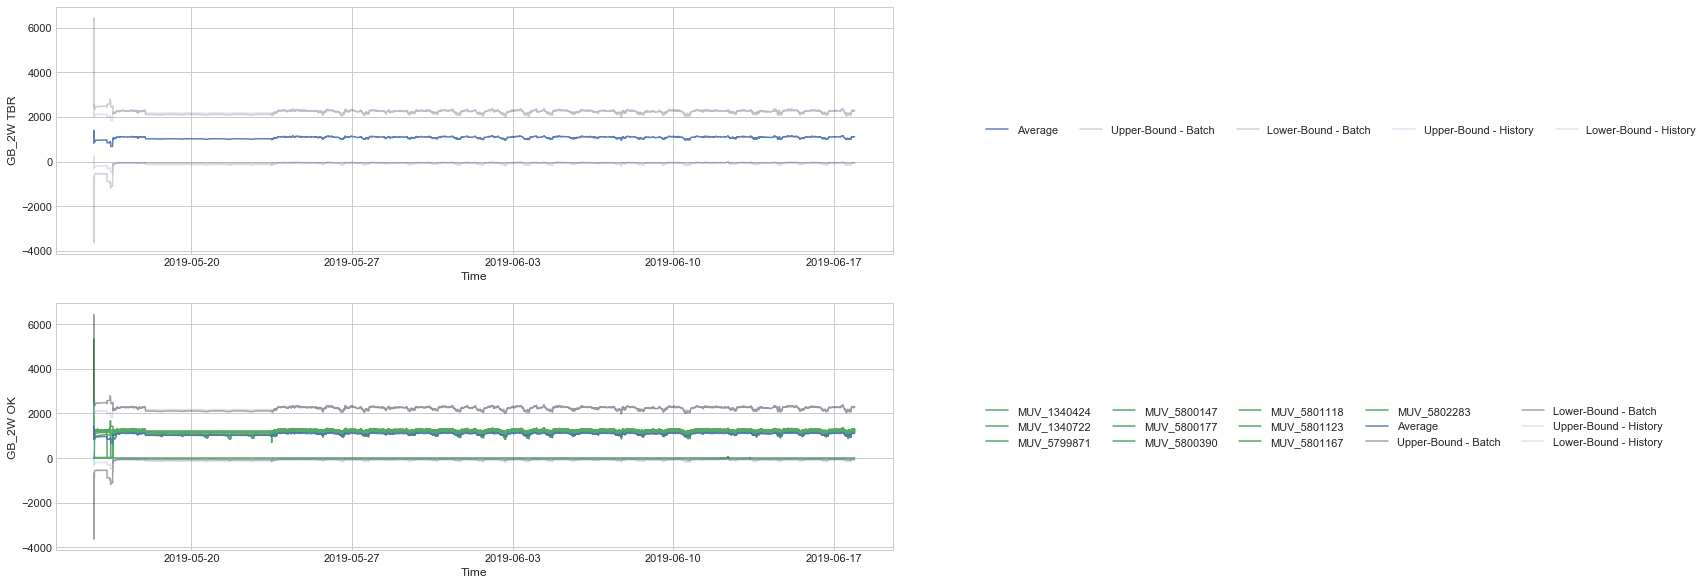

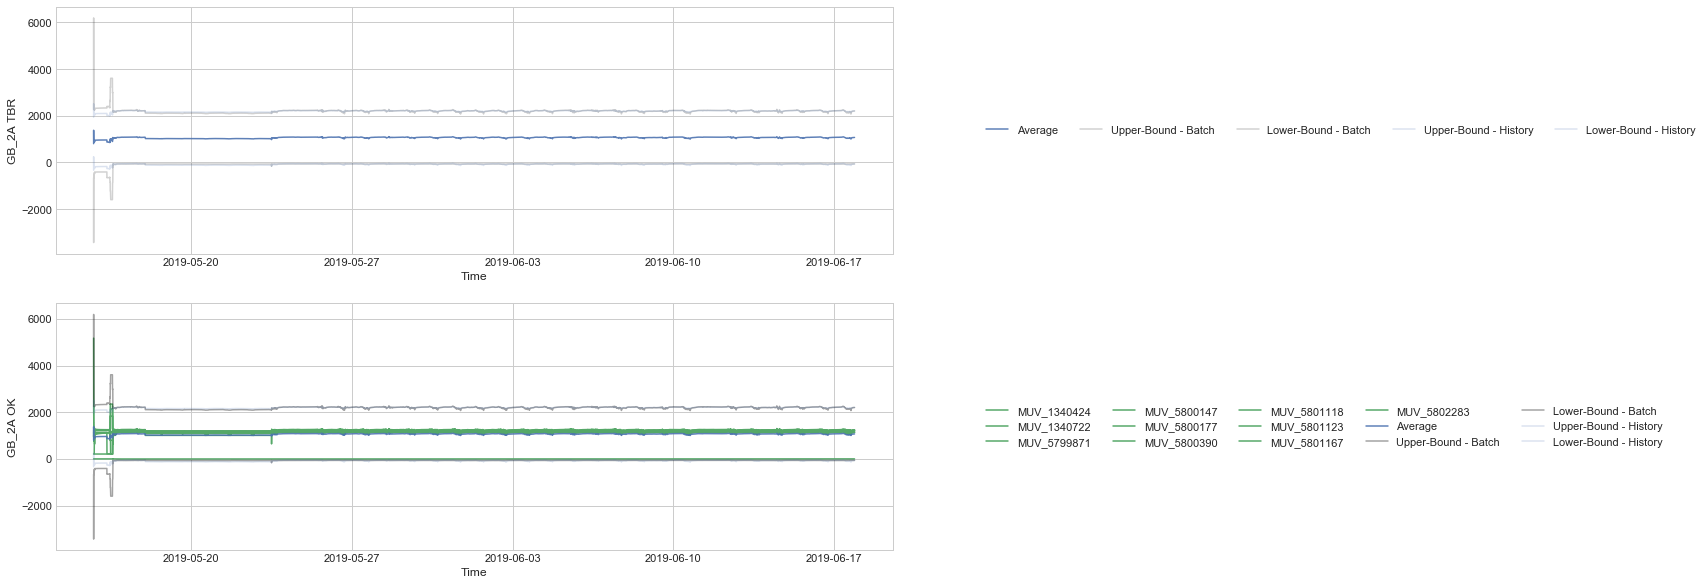

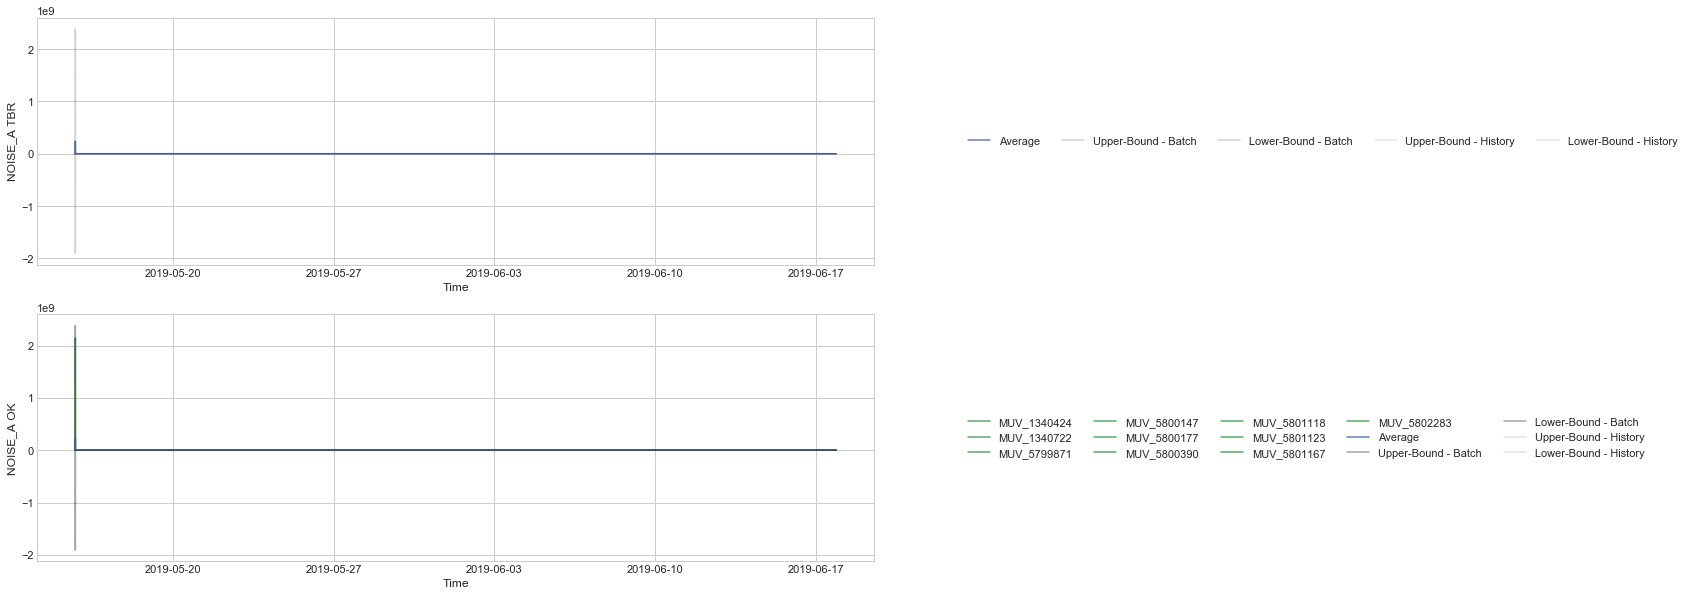

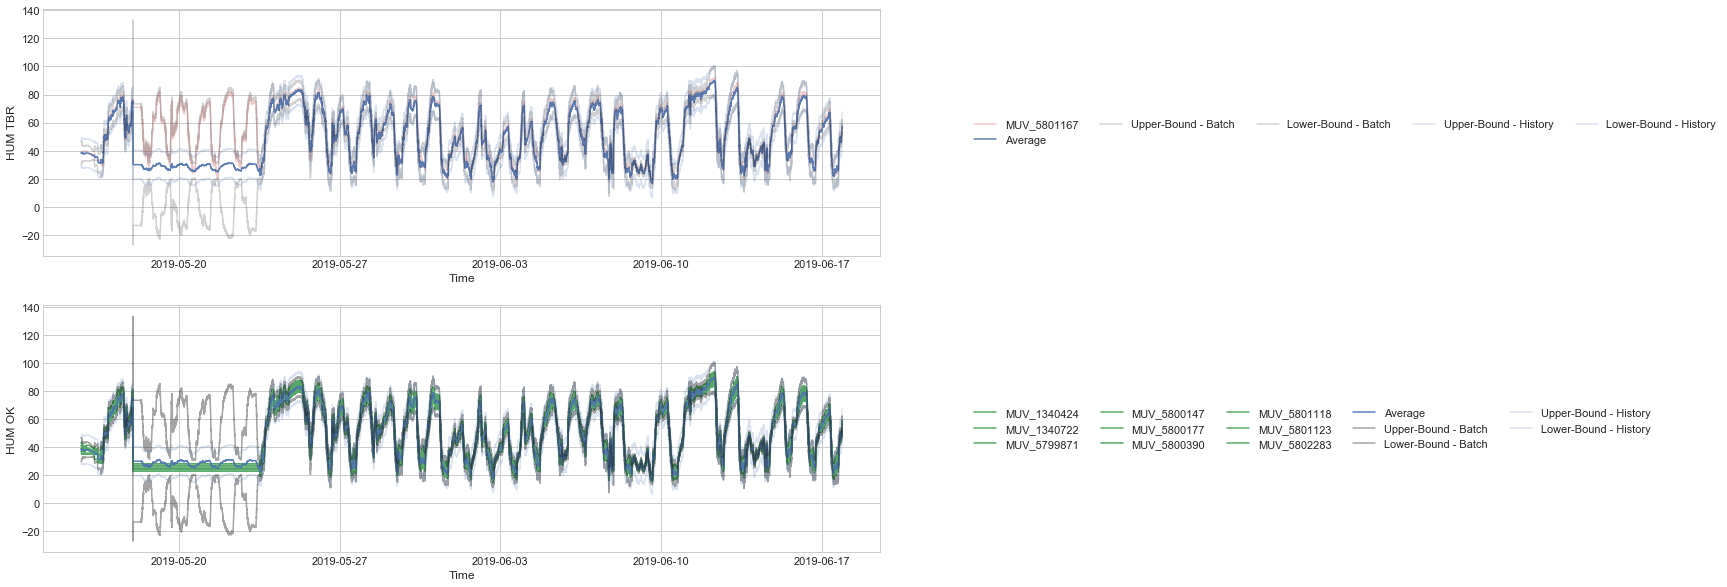

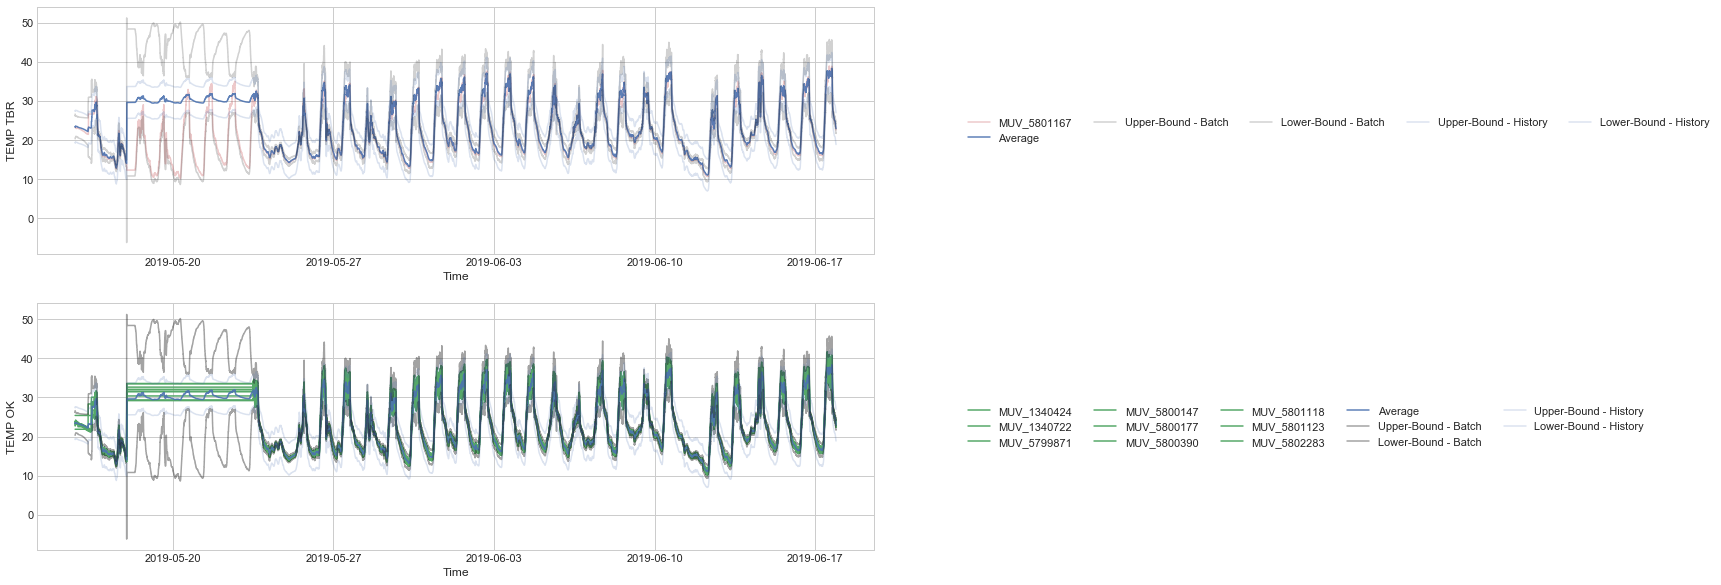

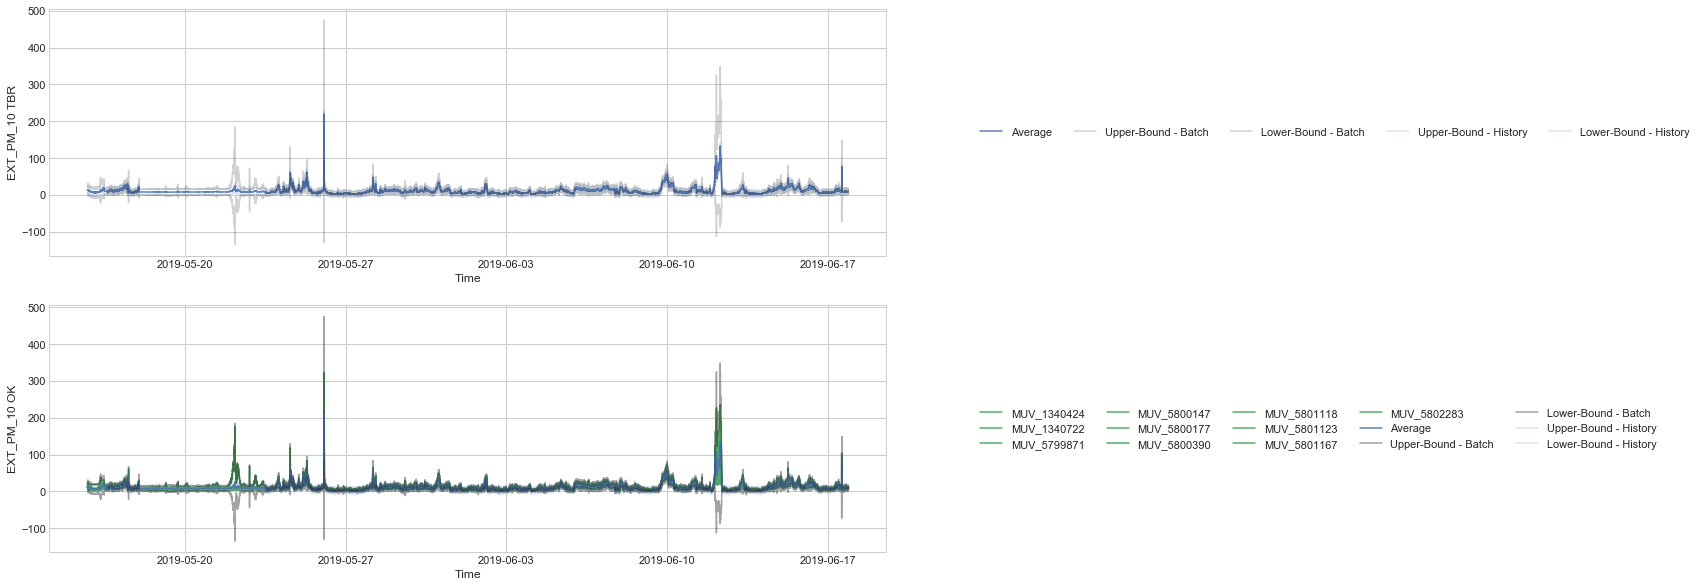

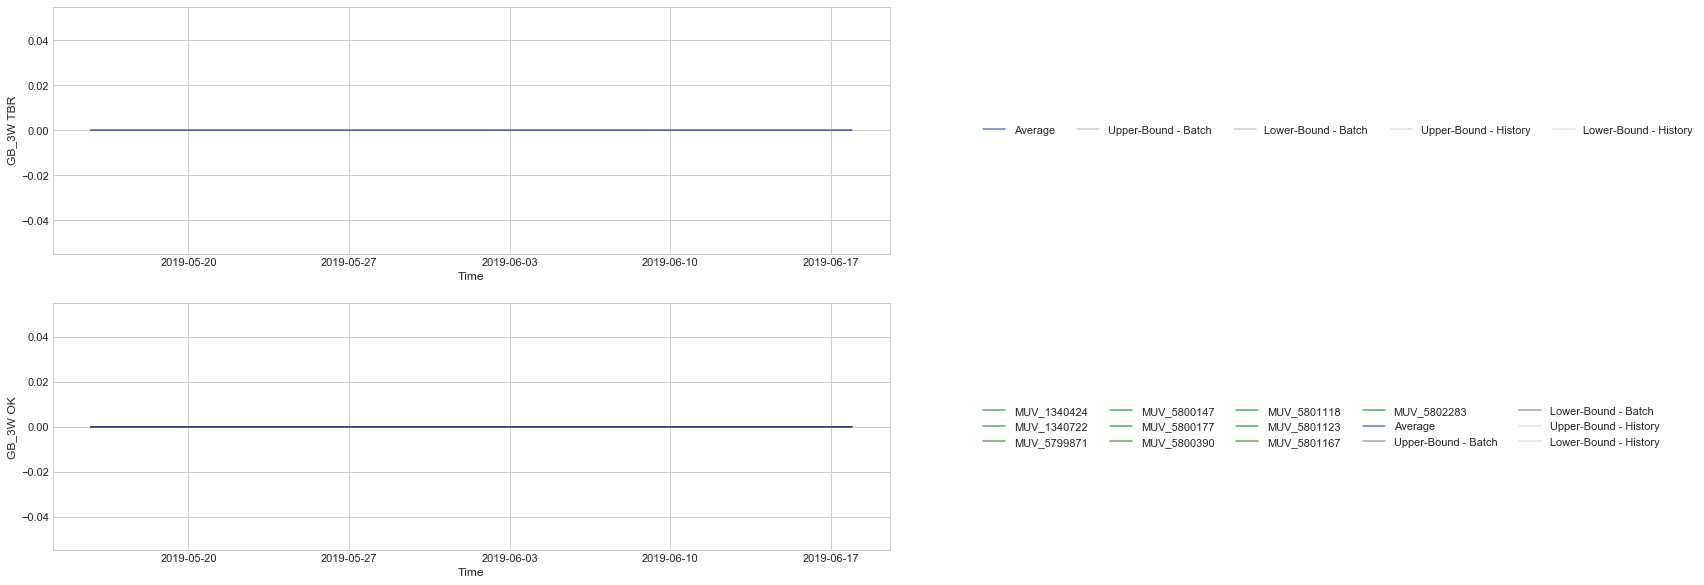

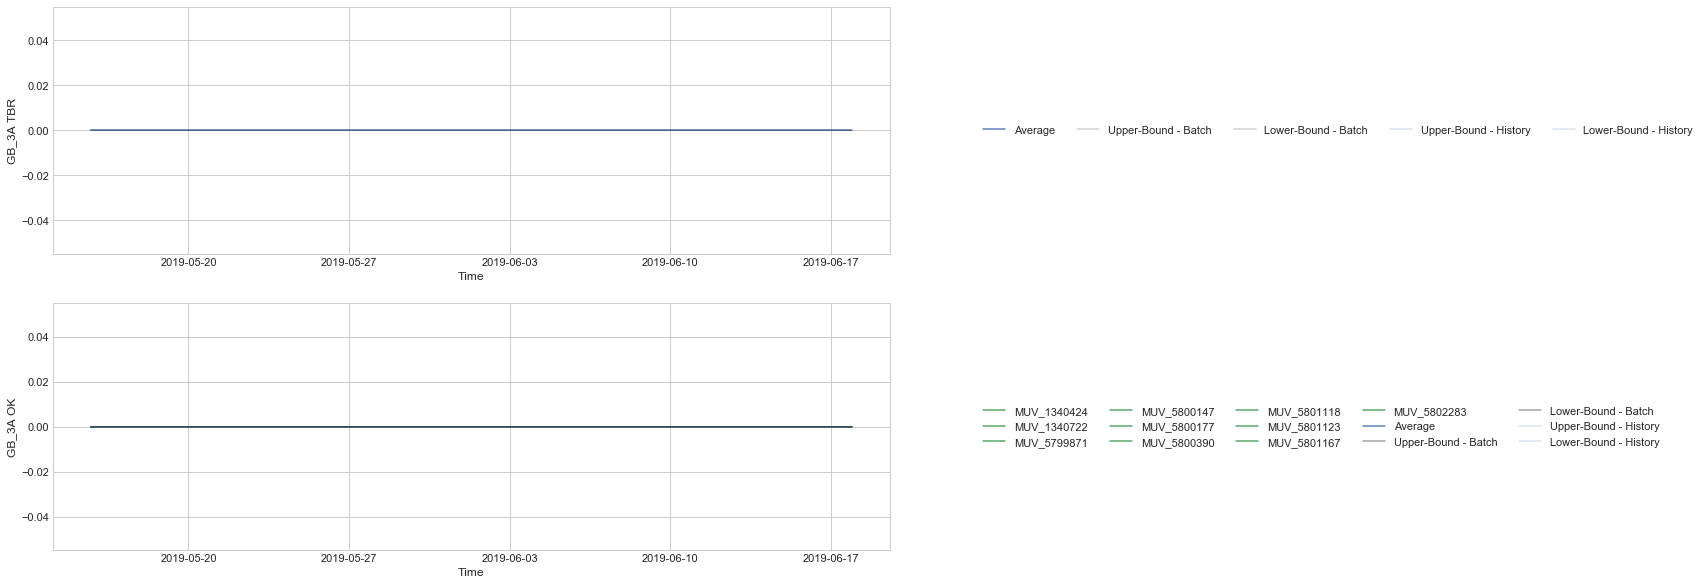

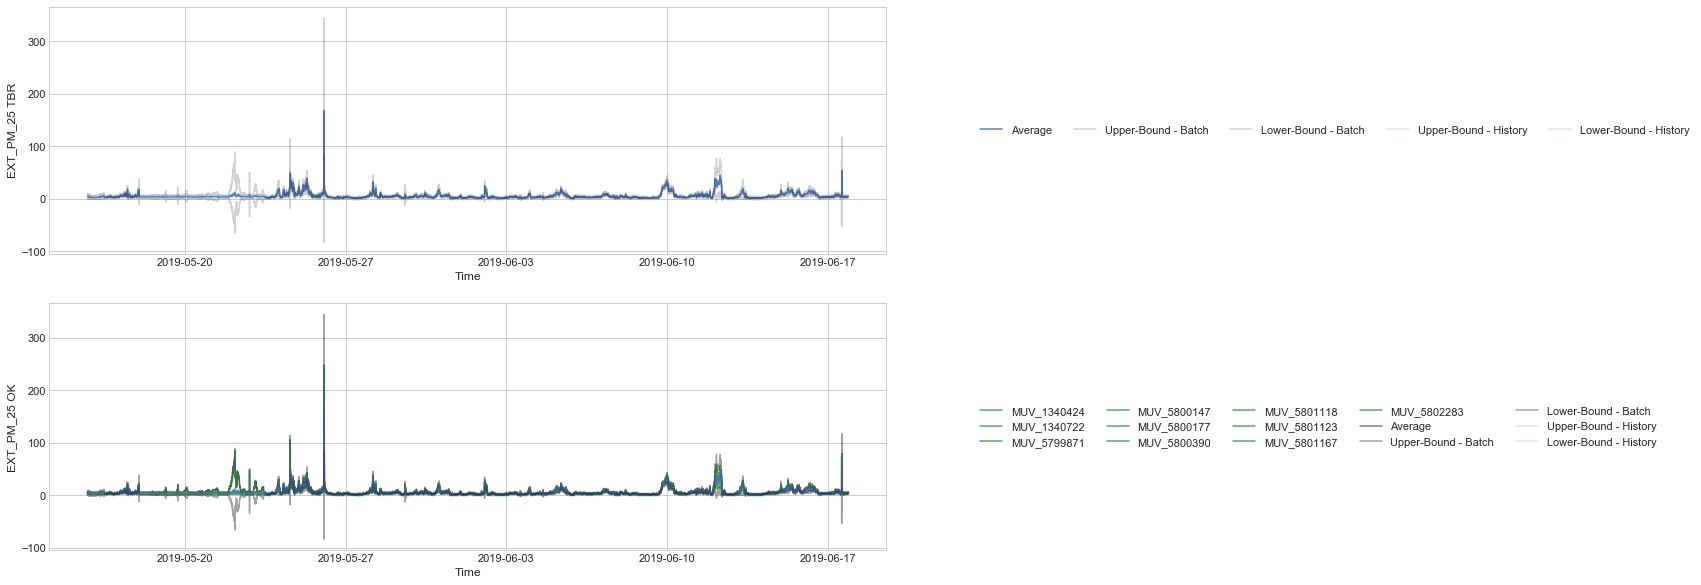

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import pickle

save_path = '/Users/macoscar/Documents/04_Projects/02_FabLab/01_SmartCitizen/01_Repositories/DataAnalysis/smartcitizen-iscape-data/data/export/figs'
limit = 10
type_file = 'png' # 'png' or 'fig' or 'nada'

## dispersion_test = 'DECODE'

list_channels = list()

# Get list of devices
list_devices = list(records.readings[dispersion_test]['devices'].keys())

# Init list of common channels
list_channels = records.readings[dispersion_test]['devices'][list_devices[0]]['data'].columns
min_date = pd.to_datetime('2000-01-01 00:00:00')
max_date = pd.to_datetime('2100-01-01 00:00:00')

min_date = min_date.tz_localize('UTC').tz_convert('Europe/Madrid')
max_date = max_date.tz_localize('UTC').tz_convert('Europe/Madrid')

# Extract list of common channels
for device in records.readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(records.readings[dispersion_test]['devices'][device]['data'].columns))
    min_date = max(records.readings[dispersion_test]['devices'][device]['data'].index[0], min_date)
    max_date = min(records.readings[dispersion_test]['devices'][device]['data'].index[-1], max_date)

print ('Min - Max Date')
print (min_date, max_date)
if 'BATT' in list_channels: list_channels.remove('BATT')
# if 'LIGHT' in list_channels: list_channels.remove('LIGHT')

print(list_channels)

# Trim dataset to min and max dates (normally these tests are carried out with _minutes_ of differences)
for device in list_devices:
    dataframe_cut = records.readings[dispersion_test]['devices'][device]['data']
    dataframe_cut = dataframe_cut[dataframe_cut.index > min_date]
    dataframe_cut = dataframe_cut[dataframe_cut.index < max_date]
    
dispersion_df = pd.DataFrame()

for channel in list_channels:
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    for device in list_devices:
        # Important to resample and bfill for unmatching measures
        dispersion_df[channel + '-' + device] = records.readings[dispersion_test]['devices'][device]['data'][channel].resample('1Min').bfill()
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_AVG'] = dispersion_df.loc[:,list_columns].mean(skipna=True, axis = 1)
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    
    dispersion_global = 0
    limit_confidence_sigma = 0
    for item in dispersion_history:
        if channel == item[0]:
            dispersion_global = item[1]
            limit_confidence_sigma = item[2]
    
    dispersion_df[channel + '_MAX'] = dispersion_df.loc[:,list_columns].max(skipna=True, axis = 1)
    dispersion_df[channel + '_MIN'] = dispersion_df.loc[:,list_columns].min(skipna=True, axis = 1)
    
    upper_bound = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_df[channel + '_STD']
    lower_bound = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_df[channel + '_STD']
    
    upper_bound2 = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_global
    lower_bound2 = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_global
        
    for device in list_devices:
        count_problems_up = dispersion_df[channel + '-' + device] > upper_bound2
        count_problems_down =  dispersion_df[channel + '-' + device] < lower_bound2
        count_problems = [1 if (count_problems_up[i] or count_problems_down[i]) else 0 for i in range(len(count_problems_up))]
        # print (channel, device, np.sum(count_problems), len(count_problems))
        if np.sum(count_problems) > len(count_problems)/limit:
        #if any(dispersion_df[channel + '-' + device] > upper_bound2) or any(dispersion_df[channel + '-' + device] < lower_bound2):
            alpha = 0.3
            color = 'r'
            ax1.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

        else:
            alpha = 1
            color = 'g'
            ax2.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

    ax1.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax1.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound - Batch', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound - Batch', alpha = 0.2)
    
    ax1.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound - History', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound - History', alpha = 0.2)
    lgd1 = ax1.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    ax1.grid(True)
    ax1.set_ylabel(channel + ' TBR')
    ax1.set_xlabel('Time')
    
    ax2.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax2.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound - Batch', alpha = 0.4)
    ax2.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound - Batch', alpha = 0.4)

    ax2.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound - History', alpha = 0.2)
    ax2.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound - History', alpha = 0.2)
    ax2.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    lgd2 = ax2.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    ax2.grid(True)
    ax2.set_ylabel(channel + ' OK')
    ax2.set_xlabel('Time')
    
    if type_file == 'fig':
        pickle.dump(fig, open(save_path + '/' + dispersion_test + '_' + channel + '.fig.pickle', 'wb'))
    elif type_file == 'png':
        fig.savefig(save_path + '/' + dispersion_test + '_' + channel + '.png', dpi=300, trasnparent = True, bbox_extra_artists=(lgd1, lgd2), bbox_inches='tight' )
        
plot.show()